# Lego CNN

In [92]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Загружаем данные

In [93]:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [94]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = np.array([img for (img, _) in train_data])
train_data_y = np.array([lbl for (_, lbl) in train_data])

test_data_X = np.array([img for (img, _) in test_data])
test_data_y = np.array([lbl for (_, lbl) in test_data])

In [95]:
train_data_X.shape

(451, 48, 48, 1)

### Меняем измерения местами так, как любит pytorch

In [96]:
train_data_X = train_data_X.transpose(0, 3, 1, 2)
test_data_X = test_data_X.transpose(0, 3, 1, 2)
train_data_X.shape

(451, 1, 48, 48)

### Делаем обучающий и тестовый датасеты

In [97]:
img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

### Классы

In [98]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


### Проверяем что все нормально отображается

Original shape is  torch.Size([1, 48, 48])


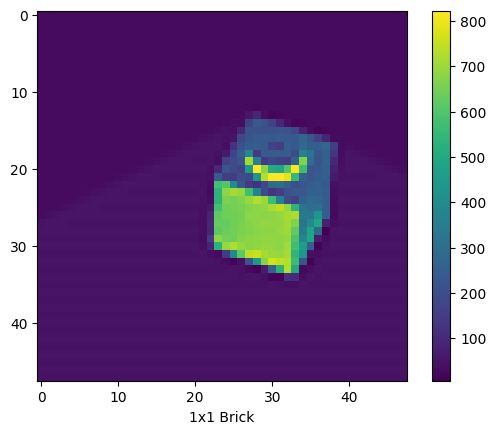

In [99]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].permute(1, 2, 0).numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

### Создаем нейронку

In [100]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Первый слой свертки и пулинга
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Второй слой свертки и пулинга
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Выпрямляем выход
        self.flatten = nn.Flatten()
        
        # Дальше идут линейные слои, работающие с выделенными признаками
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Проход всех слоев
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)

        return x


### Две обертки которые перемещают между устройствами данные и модель

In [101]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    


### Выбор девайса

In [102]:
device = 'cuda'
# device = 'cpu'

### Параметры модели

In [103]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

### Получаем модель и данные на нужных устройствах

In [104]:
train_dataloader = DeviceDataLoader(
    DataLoader(train_dataset, batch_size= BATCH_SIZE), device)
test_dataloader =  DeviceDataLoader(DataLoader(test_dataset), device)

net = to_device(Net(), device)

0.00%, train_acc: 22.71%, test_acc: 27.33%
10.00%, train_acc: 58.96%, test_acc: 76.00%
20.00%, train_acc: 86.04%, test_acc: 97.33%
30.00%, train_acc: 97.29%, test_acc: 100.00%
40.00%, train_acc: 99.58%, test_acc: 100.00%
50.00%, train_acc: 99.79%, test_acc: 100.00%
60.00%, train_acc: 99.79%, test_acc: 100.00%
70.00%, train_acc: 99.79%, test_acc: 100.00%
80.00%, train_acc: 99.79%, test_acc: 100.00%
90.00%, train_acc: 99.79%, test_acc: 100.00%


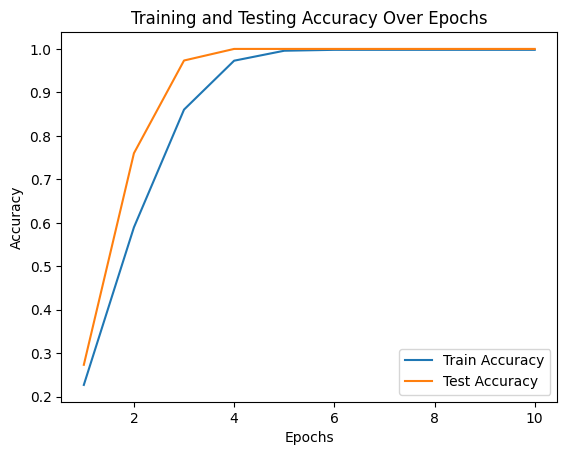

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определяем функцию потерь и метод оптимизации
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR)


# Определение функции для вычисления точности
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total


# Сюда будем заносить скоры модели в зависимости от эпохи
train_accuracies = []
test_accuracies = []

# Сам процесс обучения
for epoch in range(EPOCHS):
    # Переводим модель в режим обучения 
    net.train()
    total_train_accuracy = 0.0
    for images, labels in train_dataloader:
        # Применяем модель к данным
        outputs = net(images)
        # Вычисляем функцию потерь
        loss = criterion(outputs, labels)

        # Обнуляем градиент
        optimizer.zero_grad()
        # Вычисляем градиенты по параметрам
        loss.backward()
        # Обновляем параметры
        optimizer.step()

        # Добавляем скор на пачке к общему скору
        total_train_accuracy += accuracy(outputs, labels)

    # Считаем общий скор и добавляем в массив
    average_train_accuracy = total_train_accuracy / len(train_dataloader)
    train_accuracies.append(average_train_accuracy)

    # Переводим модель в режим оценки и считаем скор на тесте
    net.eval()
    total_test_accuracy = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = net(images)
            total_test_accuracy += accuracy(outputs, labels)
    # Получаем тестовый скор
    average_test_accuracy = total_test_accuracy / len(test_dataloader)
    test_accuracies.append(average_test_accuracy)
    # Печатаем результаты итерации
    print(f'{epoch/EPOCHS*100:.2f}%, train_acc: {average_train_accuracy*100:.2f}%,'
          f' test_acc: {average_test_accuracy*100:.2f}%')

# Построение графика
epochs_range = range(1, EPOCHS+1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.show()


## Картинка отображающая архитектуру модели

In [149]:
import torch
from torchviz import make_dot

# Создайте экземпляр вашей модели
model = to_device(net, 'cpu')

# Задайте входные данные
example_input = torch.randn(1, 1, 48, 48)  # Пример размера входных данных

# Получите выход модели
example_output = model(example_input)

# Создайте граф
graph = make_dot(example_output, params=dict(model.named_parameters()))

# Сохраните граф в файл
graph.render("model_architecture", format="png", cleanup=True)

# Отобразите граф
graph.view()


'model_architecture.pdf'

![architecture](model_architecture.png)